In [57]:
from __future__ import print_function, division
import time
from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import nilmtk
from nilmtk import metrics
from sklearn.metrics import f1_score
from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.disaggregate import CombinatorialOptimisation, FHMM
from nilmtk.elecmeter import ElecMeterID 

In [58]:
train = DataSet('./redd.h5')
test = DataSet('./redd.h5')

In [59]:
train.set_window(end="30-4-2011")
test.set_window(start="30-4-2011")

In [60]:
#train.buildings[3].elec[[1,2]] #.select_using_appliances(type=['sockets','light','CE appliance','fridge','waste disposal unit','dish washer','electric furnace','microwave','smoke alarm','unknown'])
#train.buildings[6].elec.submeters().select_top_k(k=6)

In [61]:
def predict(clf, test_elec, sample_period, timezone):
    pred = {}
    gt= {}

    for i, chunk in enumerate(test_elec.mains().load(sample_period=sample_period)):
        chunk_drop_na = chunk.dropna()
        pred[i] = clf.disaggregate_chunk(chunk_drop_na)
        gt[i]={}

        for meter in test_elec.submeters().meters:
            # Only use the meters that we trained on (this saves time!)    
            gt[i][meter] = meter.load(sample_period=sample_period).next()
        gt[i] = pd.DataFrame({k:v.squeeze() for k,v in gt[i].iteritems()}, index=gt[i].values()[0].index).dropna()
        
    # If everything can fit in memory
    gt_overall = pd.concat(gt)
    gt_overall.index = gt_overall.index.droplevel()
    pred_overall = pd.concat(pred)
    pred_overall.index = pred_overall.index.droplevel()

    # Having the same order of columns
    gt_overall = gt_overall[pred_overall.columns]
    
    #Intersection of index
    gt_index_utc = gt_overall.index.tz_convert("UTC")
    pred_index_utc = pred_overall.index.tz_convert("UTC")
    common_index_utc = gt_index_utc.intersection(pred_index_utc)
    
    
    common_index_local = common_index_utc.tz_convert(timezone)
    gt_overall = gt_overall.ix[common_index_local]
    pred_overall = pred_overall.ix[common_index_local]
    appliance_labels = [m.label() for m in gt_overall.columns.values]
    gt_overall.columns = appliance_labels
    pred_overall.columns = appliance_labels
    return gt_overall, pred_overall

In [62]:
def compute_maape(gt, pred):
    output = {}
    for appliance in gt.columns:
        output[appliance] = np.mean(np.arctan(np.abs((gt[appliance]-pred[appliance]) / gt[appliance])))
    return pd.Series(output)

In [63]:
def compute_wape(gt, pred):
    output = {}
    for appliance in gt.columns:
        output[appliance] = np.mean(np.abs(pred[appliance]-np.mean(gt[appliance])))/np.mean(gt[appliance])
    return pd.Series(output)

In [64]:
def compute_f1score(gt, pred):
    from sklearn.metrics import f1_score
    output = {}
    for appliance in gt.columns:
        output[appliance] = f1_score(gt[appliance],pred[appliance],average='weighted')
    return pd.Series(output)

In [65]:
def compute_norm_mae(gt, pred):
    output = {}
    for appliance in gt.columns:
        output[appliance] = np.sum(np.abs(pred[appliance]-gt[appliance]))/np.sum(gt[appliance])
    return pd.Series(output)

In [66]:
def compute_rmse(gt, pred):
    from sklearn.metrics import mean_squared_error
    output = {}
    for appliance in gt.columns:
        output[appliance] = np.sqrt(mean_squared_error(gt[appliance], pred[appliance]))
    return pd.Series(output)

In [67]:
# in progress
def compute_fraction_correct(gt, pred):
    output = {}
    for appliance in gt.columns:
        
        output[appliance] = min()
    return pd.Series(output)

In [68]:
wape_out = {}
f1_out = {}
mae_out = {}
rmse_out = {}

for building in [1,2]:
    print("*"*20)
    print('BUILDING NO.',building)
    print("*" *20)
    
    train_elec = train.buildings[building].elec
    test_elec = test.buildings[building].elec
    
    # select top k appliances
    top_train_elec = train_elec.submeters().select_top_k(k=5)
    
    classifiers = {'CO':CombinatorialOptimisation(), 'FHMM':FHMM()}
    predictions = {}
    sample_period = 120
    for clf_name, clf in classifiers.iteritems():
        print('\n')
        print("*"*20)
        print(clf_name)
        print("*" *20)
        clf.train(top_train_elec, sample_period=sample_period)
        gt, predictions[clf_name] = predict(clf, test_elec, sample_period, train.metadata['timezone'])
    wape = {}
    f1 = {}
    mae = {}
    rmse = {}
    for clf_name in classifiers.keys():
        wape[clf_name] = compute_wape(gt,predictions[clf_name])
        f1[clf_name] = compute_f1score(gt,predictions[clf_name])
        mae[clf_name] = compute_norm_mae(gt,predictions[clf_name])
        rmse[clf_name] = compute_rmse(gt,predictions[clf_name])
    wape_out[building] = pd.DataFrame(wape)
    f1_out[building] = pd.DataFrame(f1)
    mae_out[building] = pd.DataFrame(mae)
    rmse_out[building] = pd.DataFrame(rmse)

********************
BUILDING NO. 1
********************
15/16 MeterGroup(meters==19, building=1, dataset='REDD', appliances=[Appliance(type='unknown', instance=2)])e=1)])ce=1)])
  ElecMeter(instance=3, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
  ElecMeter(instance=4, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
16/16 MeterGroup(meters= for ElecMeterID(instance=3, building=1, dataset='REDD') ...    for ElecMeterID(instance=4, building=1, dataset='REDD') ...   
  ElecMeter(instance=10, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=20, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
Calculating total_energy for ElecMeterID(instance=20, building=1, dataset='REDD') ...   

********************
FHMM
********************
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Ap

In [ ]:
names = ['Pct. Mean Abs. Error','Weighted Abs. Pct. Error','F1 Score','RMSE']
models =[mae_out,wape_out,f1_out,rmse_out]

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                round(height,2),
                ha='center', va='bottom') 

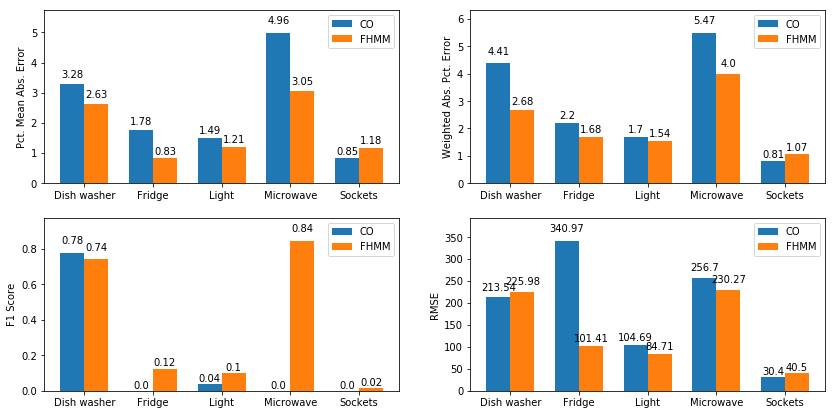

In [71]:
# House 1 performance output
fig = plt.figure()
plt.figure(figsize=(14,7))
i=221
for name,model in zip(names,models):
    #fig, ax = plt.subplots()
    width = 0.35
    N = 5
    ind = np.arange(N)
    
    ax = plt.subplot(i)
    i+=1
    CO = ax.bar(x=ind, height=model[1]['CO'], width=width)
    FHMM = ax.bar(x=ind+width, height=model[1]['FHMM'], width=width)
    ax.legend((CO[0], FHMM[0]), ('CO', 'FHMM'))
    ax.set_ylabel(name)
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(model[1].index)

    autolabel(CO)
    autolabel(FHMM)
    ymin, ymax = plt.ylim()
    plt.ylim(ymin,ymax*1.1)

plt.show()

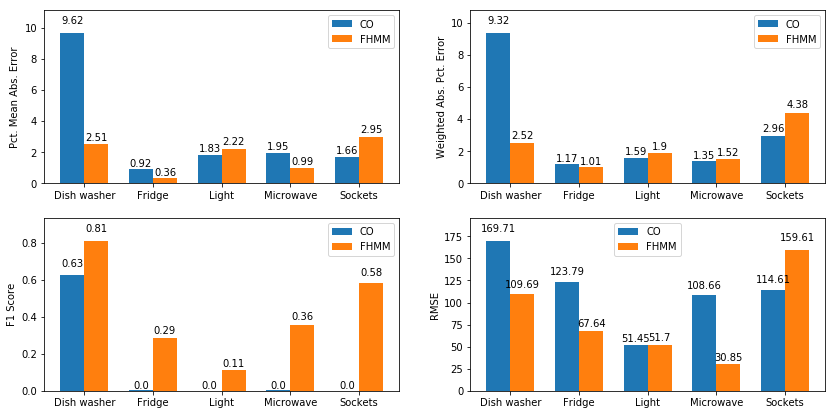

In [73]:
# House 2 performance output
fig = plt.figure()
plt.figure(figsize=(14,7))
i=221
for name,model in zip(names,models):
    #fig, ax = plt.subplots()
    width = 0.35
    N = 5
    ind = np.arange(N)
    
    ax = plt.subplot(i)
    i+=1
    CO = ax.bar(x=ind, height=model[2]['CO'], width=width)
    FHMM = ax.bar(x=ind+width, height=model[2]['FHMM'], width=width)
    ax.legend((CO[0], FHMM[0]), ('CO', 'FHMM'))
    ax.set_ylabel(name)
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(model[1].index)

    autolabel(CO)
    autolabel(FHMM)
    ymin, ymax = plt.ylim()
    plt.ylim(ymin,ymax*1.1)

plt.show()